In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [4]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [5]:
# Load the data
data = pd.read_csv("/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv")
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# **Exploring the Data**  
## **Fields and Data Types 🗒️**  

- **CustomerID**: Unique identifier assigned to each customer.  
- **Gender**: Gender of the customer (`Male` or `Female`).  
- **Age**: Age of the customer in years.  
- **Annual Income (k$)**: Customer’s yearly income in thousands of dollars.  
- **Spending Score (1-100)**: Score assigned by the business based on customer spending behavior, where `1` represents the lowest spending and `100` the highest.  

# Understanding Data

In [6]:
data.shape

(200, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# Now i going to checking the number of unique values in each column

In [8]:
dict = {}
for i in list(data.columns):
    dict[i] = data[i].value_counts().shape[0]
pd.DataFrame(dict, index=['unique count']).transpose()

,unique count
CustomerID,200
Gender,2
Age,51
Annual Income (k$),64
Spending Score (1-100),84


In [9]:
# Renames the dataset and removes the space
data=data.rename(columns={
    "Annual Income (k$)":"Annual_Income",
    "Spending Score (1-100)":"Spending_Score"
    })
data.head()

,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
# Check for missing values
print(data.isnull().sum())

CustomerID        0
Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64


# EDA (Exploratory Data Analysis)

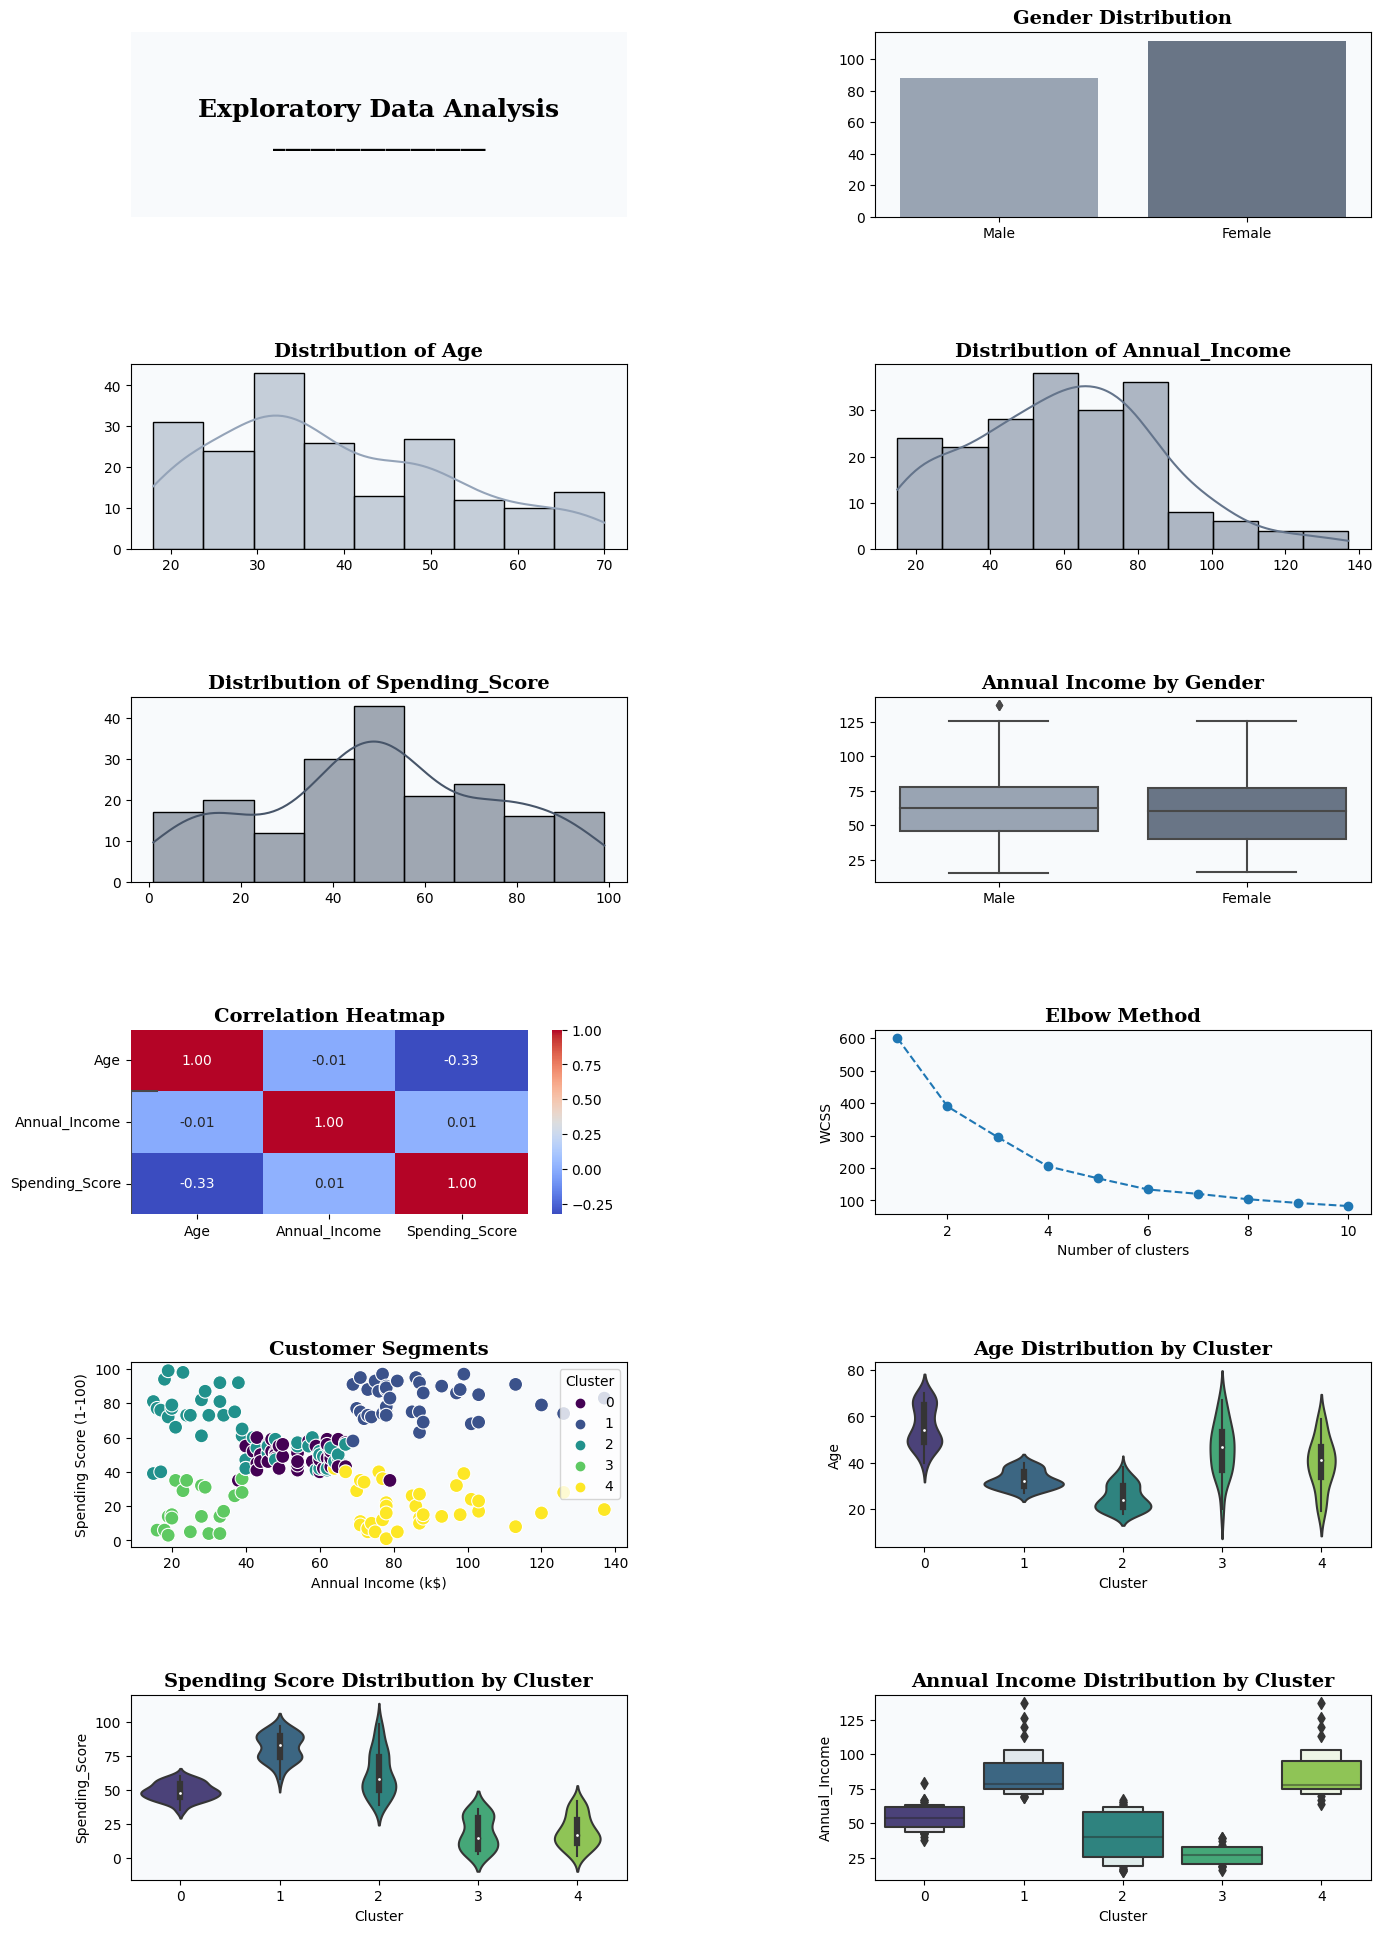

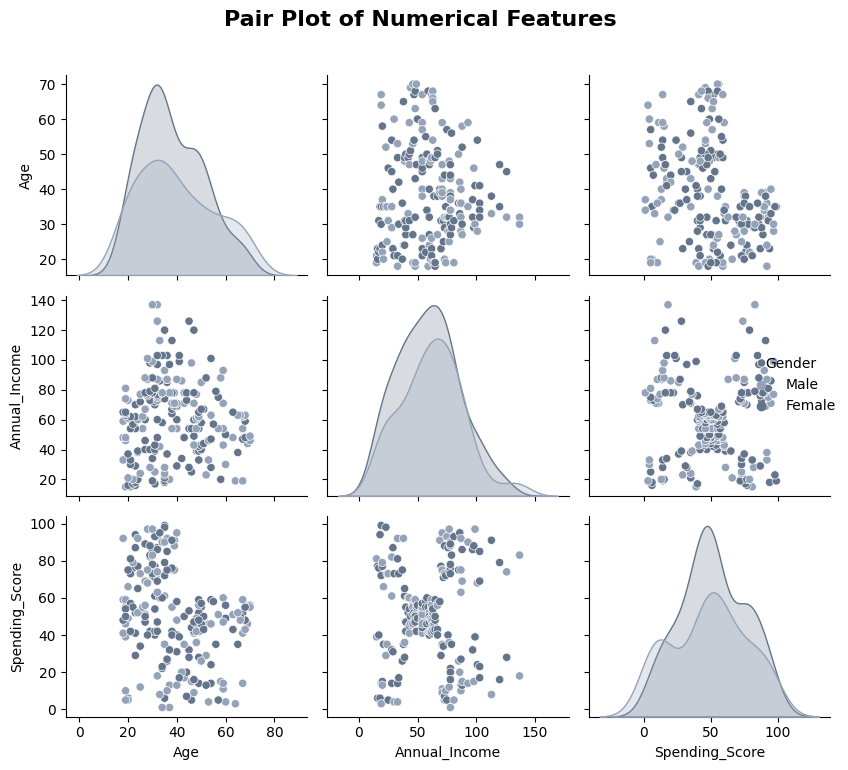

In [11]:
# General plot settings
background_color = "#f8fafc"
color_palette = ["#94a3b8", "#64748b", "#475569", "#334155", "#1e293b"]

# Adjust figure size and layout
fig = plt.figure(figsize=(16, 24))  
gs = fig.add_gridspec(6, 2)  
gs.update(wspace=0.5, hspace=0.8)  

# Create axes for each subplot
axes = [fig.add_subplot(gs[i, j]) for i in range(6) for j in range(2)]
for ax in axes:
    ax.set_facecolor(background_color)

# Title of the plot
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(0.5, 0.5,
             'Exploratory Data Analysis\n_________________',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=18, fontweight='bold',
             fontfamily='serif',
             color="#000000")

# Count plots for categorical features
sns.countplot(ax=axes[1], data=data, x='Gender', palette=color_palette)
axes[1].set_title("Gender Distribution", loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# Distribution plots for numerical features
numerical_features = ['Age', 'Annual_Income', 'Spending_Score']
for i, feature in enumerate(numerical_features):
    ax = axes[i + 2]  
    sns.histplot(ax=ax, data=data, x=feature, kde=True, color=color_palette[i % len(color_palette)])
    ax.set_title(f"Distribution of {feature}", loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Boxplots for numerical vs. categorical relationships
boxplot_pairs = [('Annual_Income', 'Gender'), ('Spending_Score', 'Gender')]
boxplot_titles = ["Annual Income by Gender", "Spending Score by Gender"]
for i, (num, cat) in enumerate(boxplot_pairs):
    ax = axes[i + 5]
    sns.boxplot(ax=ax, data=data, x=cat, y=num, palette=color_palette)
    ax.set_title(boxplot_titles[i], loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Pair plot for numerical features
sns.pairplot(data=data.drop('CustomerID', axis=1), hue='Gender', diag_kind='kde', palette=color_palette)
plt.suptitle('Pair Plot of Numerical Features', fontsize=16, fontweight='bold', y=1.02)

# Heatmap for correlation between numerical features
corr = data[['Age', 'Annual_Income', 'Spending_Score']].corr()
sns.heatmap(ax=axes[6], data=corr, annot=True, cmap="coolwarm", fmt=".2f")
axes[6].set_title("Correlation Heatmap", fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Elbow Method to determine the optimal number of clusters
X = data[['Age', 'Annual_Income', 'Spending_Score']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

axes[7].plot(range(1, 11), wcss, marker='o', linestyle='--')
axes[7].set_title('Elbow Method', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
axes[7].set_xlabel("Number of clusters")
axes[7].set_ylabel("WCSS")

# Based on the Elbow Method, choose the optimal number of clusters (e.g., 5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original data
data['Cluster'] = clusters

# Visualize the clusters
sns.scatterplot(ax=axes[8], x='Annual_Income', y='Spending_Score', hue='Cluster', data=data, palette='viridis', s=100)
axes[8].set_title('Customer Segments', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
axes[8].set_xlabel("Annual Income (k$)")
axes[8].set_ylabel("Spending Score (1-100)")

# Violin plots for Age and Spending Score by Cluster
sns.violinplot(ax=axes[9], x='Cluster', y='Age', data=data, palette='viridis')
axes[9].set_title('Age Distribution by Cluster', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

sns.violinplot(ax=axes[10], x='Cluster', y='Spending_Score', data=data, palette='viridis')
axes[10].set_title('Spending Score Distribution by Cluster', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Boxen plots for Annual Income by Cluster
sns.boxenplot(ax=axes[11], x='Cluster', y='Annual_Income', data=data, palette='viridis')
axes[11].set_title('Annual Income Distribution by Cluster', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

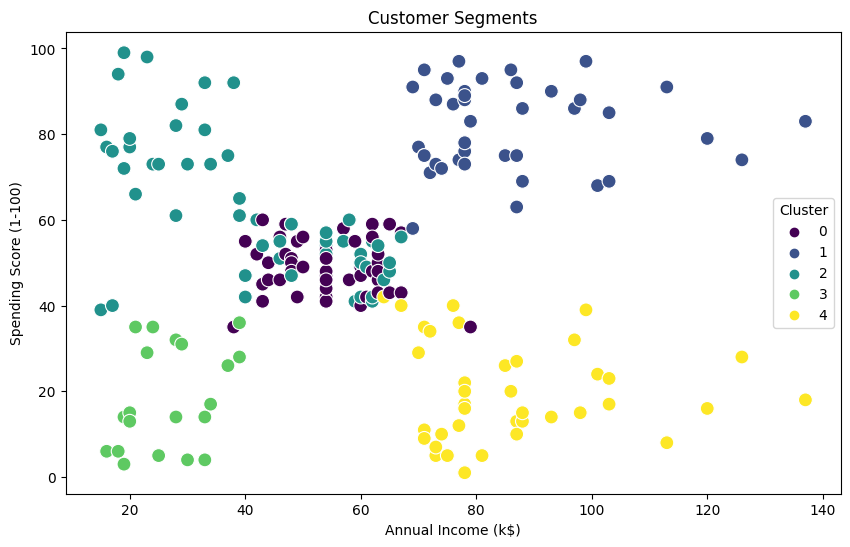

In [12]:
# Based on the Elbow Method, choose the optimal number of clusters (e.g., 5)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original data
data['Cluster'] = clusters

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='Cluster', data=data, palette='viridis', s=100)
plt.title('Customer Segments')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

In [13]:
# Interpret the clusters
cluster_summary = data.groupby('Cluster').agg({
    'Age': 'mean',
    'Annual_Income': 'mean',
    'Spending_Score': 'mean'
}).reset_index()
print(cluster_summary)

# Silhouette Score to evaluate the clustering
silhouette_avg = silhouette_score(X_scaled, clusters)
print(f'Silhouette Score: {silhouette_avg:.2f}')

   Cluster        Age  Annual_Income  Spending_Score
0        0  55.638298      54.382979       48.851064
1        1  32.875000      86.100000       81.525000
2        2  25.185185      41.092593       62.240741
3        3  46.250000      26.750000       18.350000
4        4  39.871795      86.102564       19.358974
Silhouette Score: 0.42


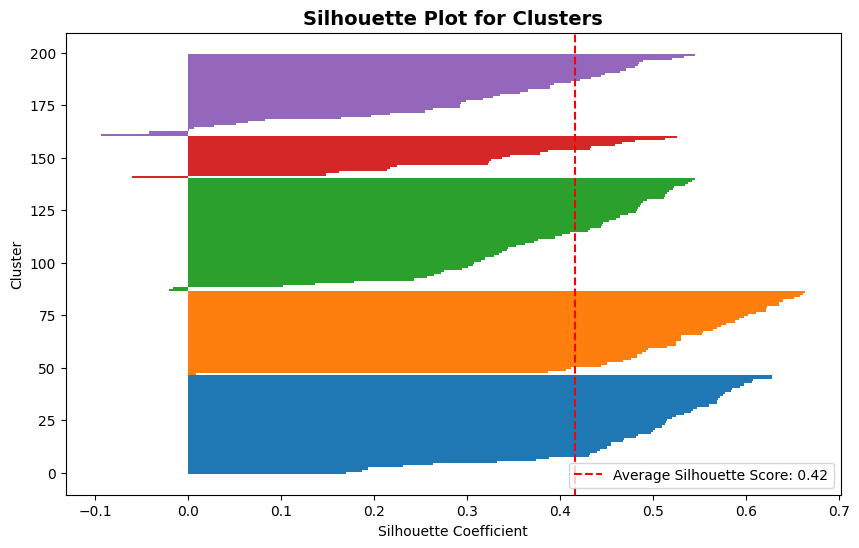

In [16]:
# Silhouette analysis
silhouette_vals = silhouette_samples(X_scaled, clusters)

# Silhouette plot
plt.figure(figsize=(10, 6))
y_lower, y_upper = 0, 0
for i in range(n_clusters):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
    y_lower += len(cluster_silhouette_vals)

plt.axvline(silhouette_avg, color='red', linestyle='--', label=f'Average Silhouette Score: {silhouette_avg:.2f}')
plt.title('Silhouette Plot for Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.legend()
plt.show()

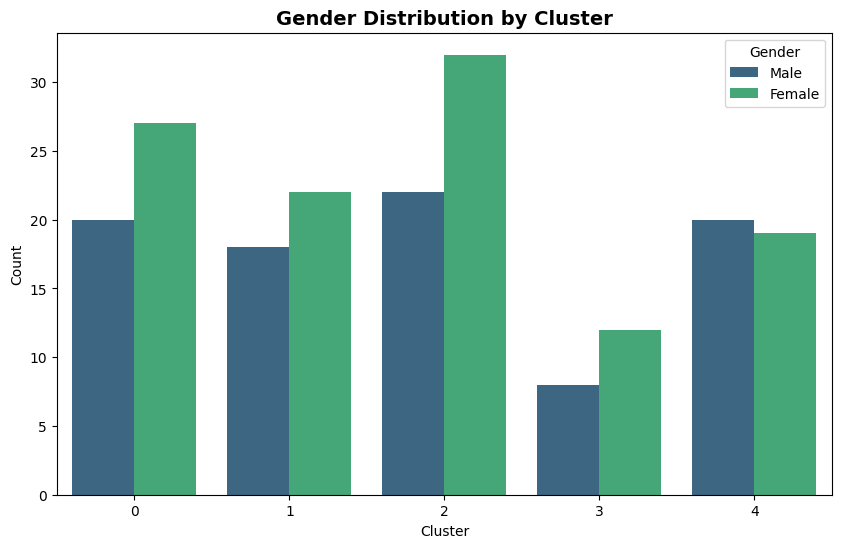

In [17]:
# Gender distribution in clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Gender', data=data, palette='viridis')
plt.title('Gender Distribution by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

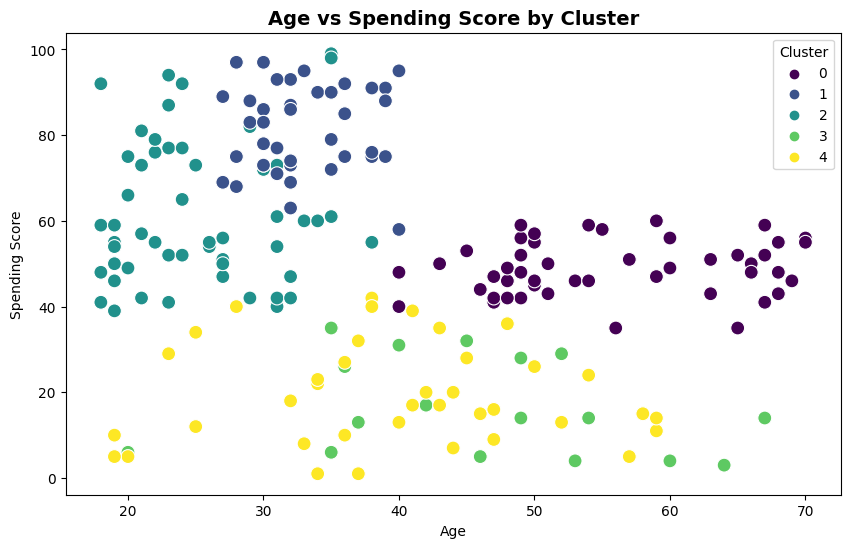

In [18]:
# Age vs Spending Score by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Spending_Score', hue='Cluster', data=data, palette='viridis', s=100)
plt.title('Age vs Spending Score by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.show()

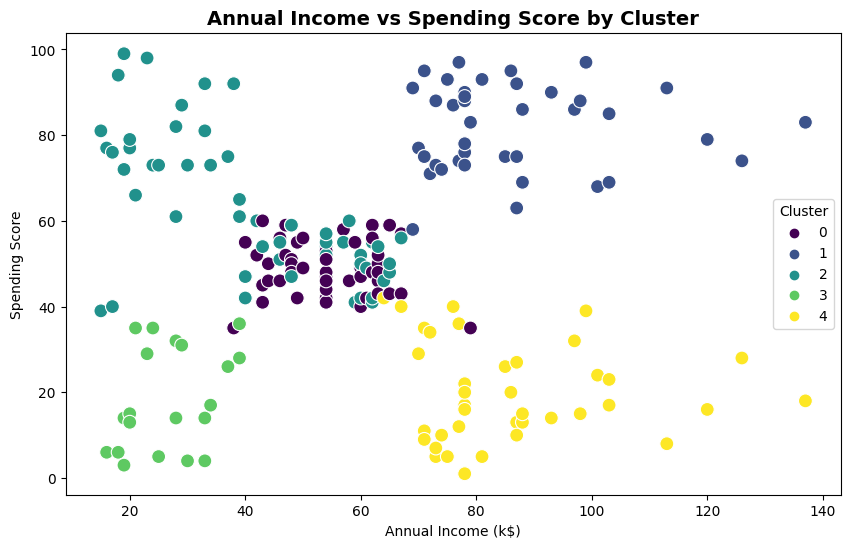

In [19]:
# Annual Income vs Spending Score by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='Cluster', data=data, palette='viridis', s=100)
plt.title('Annual Income vs Spending Score by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score')
plt.show()

In [20]:
# Save the model for future use
joblib.dump(kmeans, 'customer_segmentation_kmeans.pkl')
print("Model saved as 'customer_segmentation_kmeans.pkl'.")

Model saved as 'customer_segmentation_kmeans.pkl'.


In [21]:
# Example: Predicting clusters for new data
new_customers = pd.DataFrame({
    'Age': [25, 45, 35],
    'Annual_Income': [50, 90, 120],
    'Spending_Score': [70, 30, 85]
})

# Scale the new data
new_customers_scaled = scaler.transform(new_customers)

# Predict clusters
new_customers['Cluster'] = kmeans.predict(new_customers_scaled)
print("Predicted Clusters for New Customers:")
print(new_customers)

Predicted Clusters for New Customers:
   Age  Annual_Income  Spending_Score  Cluster
0   25             50              70        2
1   45             90              30        4
2   35            120              85        1


# Application in Marketing

**Cluster Interpretation**:
- Cluster 0: Middle-aged customers with moderate income and high spending score.
- Cluster 1: Younger customers with low income and high spending score.
- Cluster 2: Older customers with low income and low spending score.
- Cluster 3: Younger customers with high income and high spending score.
- Cluster 4: Middle-aged customers with high income and low spending score.

**Marketing Strategy**:
- Target Cluster 0 and Cluster 1 with personalized offers to maintain their high spending.
- For Cluster 3, focus on premium products and loyalty programs.
- For Cluster 2 and Cluster 4, consider strategies to increase their engagement and spending.

# **Conclusion and Recommendations**

- **Cluster 0 and 1**: High spending potential. Focus on loyalty programs and personalized offers.
- **Cluster 3**: High-income customers. Target with premium and exclusive products.
- **Cluster 2 and 4**: Low engagement. Use discounts and promotions to increase spending.